In [3]:
import openturns as ot
import importlib.util
import sys
import os
import pandas as pd

# Load the flood model
module_name = "FloodModel"
file_path = "examples/Water.py"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

spec = importlib.util.spec_from_file_location(module_name, file_path)
if spec is None:
    raise ImportError(f"Could not load the module from {file_path}.")

module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

function_of_interest, problem = module.model, module.problem

# Create distributions
distributions = ot.DistributionCollection()
for dist_info in problem['distributions']:
    dist_type = dist_info['type']
    params = dist_info['params']
    if dist_type == 'Uniform':
        distributions.add(ot.Uniform(*params))
    elif dist_type == 'Normal':
        distributions.add(ot.Normal(*params))
    elif dist_type == 'LogNormalMuSigma':
        distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
    elif dist_type == 'LogNormal':
        distributions.add(ot.LogNormal(*params))
    elif dist_type == 'Beta':
        distributions.add(ot.Beta(*params))
    elif dist_type == 'Gumbel':
        distributions.add(ot.Gumbel(*params))
    elif dist_type == 'Triangular':
        distributions.add(ot.Triangular(*params))
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

distribution = ot.ComposedDistribution(distributions)

# Define the OpenTURNS model
ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)

# Draw the function
n = 10000
sampleX = distribution.getSample(n)
sampleY = ot_model(sampleX)

# Save data used in plotXvsY to CSV
sampleX.exportToCSVFile("results/X.csv", ",")
sampleY.exportToCSVFile("results/Y.csv", ",")


X = pd.read_csv('results/X.csv')
Y = pd.read_csv('results/Y.csv')

X.columns = problem['names']

grid_df = pd.concat([Y, X], axis=1)
grid_df.to_csv('results/grid.csv')

# Estimate the Sobol' indices
size = 1000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
input_names = problem['names']
inputDesign.setDescription(input_names)
inputDesign.getSize()

outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

# Use the provided code to create DataFrames for Sobol indices
rows = str(sensitivityAnalysis.getFirstOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getFirstOrderIndices()).strip('[]').split(',')))})
first_order_df = pd.concat([new_df, df], axis=1)

rows = str(sensitivityAnalysis.getTotalOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getTotalOrderIndices()).strip('[]').split(',')))})
total_order_df = pd.concat([new_df, df], axis=1)

# Save Sobol indices to CSV
first_order_df.to_csv("results/first_order_sobol_indices.csv", index=False)
total_order_df.to_csv("results/total_order_sobol_indices.csv", index=False)


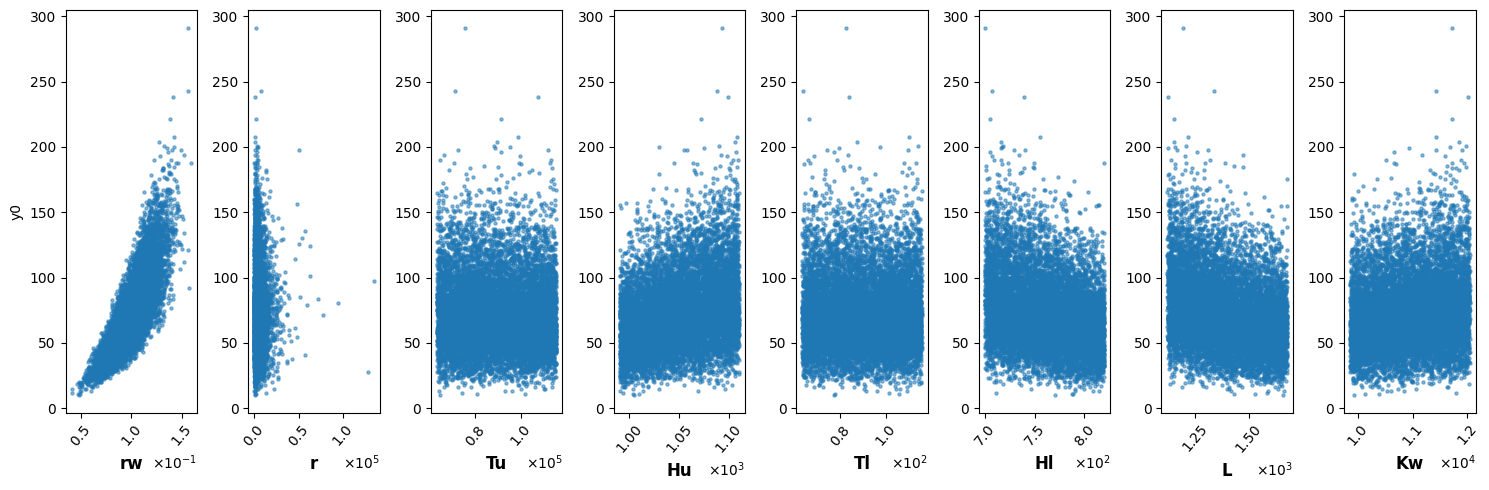

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Load the CSV file
csv_file = 'results/grid.csv'

df = pd.read_csv(csv_file)

# Extract the columns
y = df['y0']
X = df.drop(columns=['y0', 'Unnamed: 0'])

# Get the column names
X_names = X.columns

# Define the dimensions
dimX = X.shape[1]

# Create a grid of plots
fig, axes = plt.subplots(1, dimX, figsize=(15, 5))

# Plot each subplot
for j in range(dimX):
    ax = axes[j] if dimX > 1 else axes
    ax.scatter(X.iloc[:, j], y, alpha=0.5, s=5)
    ax.set_xlabel(X_names[j], fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=50)  # Rotate x-ticks vertically
    if j == 0:
        ax.set_ylabel('y0')
    else:
        ax.set_ylabel("")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

plt.tight_layout()
plt.show()

